## Predict delta PSI of GTEx A3SS events

In [1]:
import kipoi
from kipoi.model import KerasModel
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
%matplotlib inline 

from mmsplice.exon_dataloader import ExonDataset
from mmsplice import MMSplice
from mmsplice.generic import get_var_side, logit, expit
from mmsplice.utils.postproc import transform

from kipoi.data import DataLoader
from kipoi.data_utils import numpy_collate

from keras.models import load_model
from concise.preprocessing import encodeDNA

%load_ext autoreload
%autoreload 2

projectDIR = "../../data/"

/opt/modules/i12g/anaconda/3-5.0.1/envs/mmsplice-manuscript/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/modules/i12g/anaconda/3-5.0.1/envs/mmsplice-manuscript/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/modules/i12g/anaconda/3-5.0.1/envs/mmsplice-manuscript/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/opt/modules/i12g/anaconda/3-5.0.1/envs/mmsplice-manuscript/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator HuberRegressor from version 0.19.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  

In [2]:
dl1 = ExonDataset(projectDIR+"gtex/A3SS_SA1_variant.csv",
           projectDIR+"shared/hg19.fa", split_seq=False, overhang=(100,100))

In [3]:
dl2 = ExonDataset(projectDIR+"gtex/A3SS_SA2_variant.csv",
           projectDIR+"shared/hg19.fa", split_seq=False, overhang=(100,100))

In [4]:
dl1 = DataLoader(dl1, batch_size=dl1.__len__(), collate_fn=numpy_collate, shuffle=False)
dl1 = iter(dl1)
dt1 = next(dl1)

In [5]:
dl2 = DataLoader(dl2, batch_size=dl2.__len__(), collate_fn=numpy_collate, shuffle=False)
dl2 = iter(dl2)
dt2 = next(dl2)

In [6]:
csv = projectDIR+"gtex/A3SS_SA1_variant.csv"
csvf = pd.read_csv(csv, sep=',', index_col=0)

In [7]:
csvf['side'] = list(map(get_var_side,
                         zip(csvf['variant_position'],
                             csvf['REF'],
                             csvf['ALT'],
                             csvf['exon_start'], csvf['exon_end'],
                             csvf['strand'])))
csvf['REF_SEQ'] = dt1['inputs']['seq']
csvf['ALT_SEQ'] = dt1['mut_inputs']['seq']

## Prediction

In [8]:
model = MMSplice(
         exon_cut_l=0,
         exon_cut_r=0,
         acceptor_intron_cut=6,
         donor_intron_cut=6,
         acceptor_intron_len=50,
         acceptor_exon_len=3,
         donor_exon_len=5,
         donor_intron_len=13)

/opt/modules/i12g/anaconda/3-5.0.1/envs/mmsplice-manuscript/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [9]:
ref_pred1 = model.predict_on_unsplitted_batch(dt1['inputs'])
alt_pred1 = model.predict_on_unsplitted_batch(dt1['mut_inputs'])

/opt/modules/i12g/anaconda/3-5.0.1/envs/mmsplice-manuscript/lib/python3.6/site-packages/mmsplice/mmsplice.py:162: UserWarning: None GT donor
  warnings.warn("None GT donor", UserWarning)
/opt/modules/i12g/anaconda/3-5.0.1/envs/mmsplice-manuscript/lib/python3.6/site-packages/mmsplice/mmsplice.py:164: UserWarning: None AG donor
  warnings.warn("None AG donor", UserWarning)


In [10]:
X1 = alt_pred1-ref_pred1

In [11]:
X1 = transform(X1)

In [12]:
from sklearn.externals import joblib
huber = joblib.load(projectDIR+'vexseq/scale_model.pkl')

In [13]:
delt_pred1 = huber.predict(X1)

In [14]:
ref_pred2 = model.predict_on_unsplitted_batch(dt2['inputs'])
alt_pred2 = model.predict_on_unsplitted_batch(dt2['mut_inputs'])

/opt/modules/i12g/anaconda/3-5.0.1/envs/mmsplice-manuscript/lib/python3.6/site-packages/mmsplice/mmsplice.py:162: UserWarning: None GT donor
  warnings.warn("None GT donor", UserWarning)
/opt/modules/i12g/anaconda/3-5.0.1/envs/mmsplice-manuscript/lib/python3.6/site-packages/mmsplice/mmsplice.py:164: UserWarning: None AG donor
  warnings.warn("None AG donor", UserWarning)


In [15]:
X2 = alt_pred2-ref_pred2

In [16]:
X2 = transform(X2)

In [17]:
delt_pred2 = huber.predict(X2)

In [18]:
delt_pred = delt_pred2 - delt_pred1

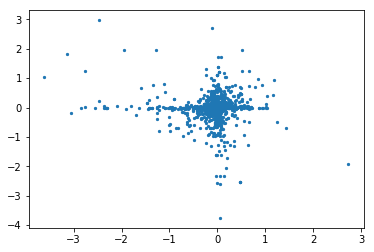

In [19]:
plt.scatter( delt_pred1 , delt_pred2, s=5)
plt.show()

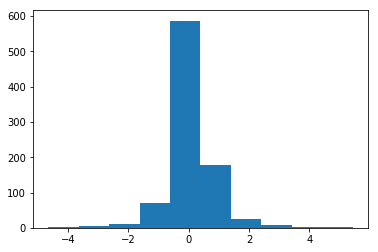

In [20]:
plt.hist(delt_pred)
plt.show()

## Evaluate prediction

In [21]:
df = pd.read_csv(projectDIR+"gtex/A3SS_PSI.csv", index_col=0)
df = df.reset_index()

Filter events with only few sample support

In [22]:
df.shape

(888, 9)

In [23]:
ref_psi = df['WT_MEAN'].as_matrix()
s2_s1 = np.log(1/ref_psi - 1)
PSI_MUT = (1 / (1+np.exp(s2_s1 + delt_pred)))
delta_PSI = PSI_MUT - ref_psi
delta_PSI_HETERO = (PSI_MUT+ref_psi)/2 - ref_psi

/opt/modules/i12g/anaconda/3-5.0.1/envs/mmsplice-manuscript/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


In [24]:
df['HOMO_dPSI'] = delta_PSI
df['HETERO_dPSI'] = delta_PSI_HETERO

In [25]:
df_HOMO = df[~df.HOMO_MEAN.isna()]
df_HETERO = df[~df.HETERO_MEAN.isna()]

In [26]:
df_HOMO.shape

(243, 11)

In [27]:
df_HETERO.shape

(884, 11)

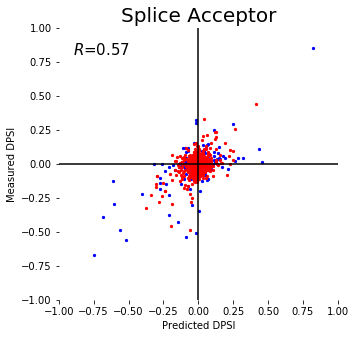

In [28]:
pred = np.concatenate([df_HOMO['HOMO_dPSI'], df_HETERO['HETERO_dPSI']])
measured = np.concatenate([df_HOMO['HOMO_MEAN'] - df_HOMO['WT_MEAN'], df_HETERO['HETERO_MEAN'] - df_HETERO['WT_MEAN']])
r = pearsonr(pred, measured)[0]

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.axis([-1,1,-1,1])
ax.scatter(df_HOMO['HOMO_dPSI'], df_HOMO['HOMO_MEAN'] - df_HOMO['WT_MEAN'], s=5, c='b')
ax.scatter(df_HETERO['HETERO_dPSI'], df_HETERO['HETERO_MEAN'] - df_HETERO['WT_MEAN'], s=5, c='r')
ax.text(-0.9,0.9,'$R$=%0.2f' %r,fontsize=15,ha='left',va='top')
ax.set_xlabel("Predicted DPSI")
ax.set_ylabel("Measured DPSI")
ax.set_title("Splice Acceptor", fontsize=20)
ax.axhline(y=0,c='k')
ax.axvline(x=0,c='k')
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [29]:
df_HOMO.to_csv(projectDIR + "gtex/SA_HOMO.csv")
df_HETERO.to_csv(projectDIR + "gtex/SA_HETERO.csv")